# Working With Model

In [29]:
import pandas as pd # data handling
import numpy as np # linear algebra
import matplotlib.pyplot as plt # visualization
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer # convert text into numerical features
from sklearn.linear_model import LogisticRegression # use Logistic Regression model as it's in safe and unsafe (binary)
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import pytesseract
import cv2
from PIL import Image

pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

## 1. Data Preprocessing

### 1.1. Data labeling

In [4]:
# data labelling
unsafe_ing = pd.read_csv(r"C:\Users\ASUS\OneDrive\KIT\Semester3\MachineLearningWithPython\ml_project2\datasets\cosing_data_cleaned.csv")

safe_ing = pd.read_csv(r"C:\Users\ASUS\OneDrive\KIT\Semester3\MachineLearningWithPython\ml_project2\datasets\filtered_huggingface.csv")

# add labels
unsafe_ing['label'] = 'unsafe'
safe_ing['label'] = 'safe'

# standardize the column name
# so that CosIng got the same column name as huggingface
unsafe_ing.rename(columns={'chemical name inn': 'ingredient'}, inplace=True)


### 1.2. Data Merge

In [5]:

# now combine them
merged_df = pd.concat([safe_ing, unsafe_ing], ignore_index=True)

# drop the unname column (don't know where it come from TT)
merged_df= merged_df.drop(columns="Unnamed: 0")

# save as csv
merged_df.to_csv(r"C:\Users\ASUS\OneDrive\KIT\Semester3\MachineLearningWithPython\ml_project2\datasets\labeled_ingredients.csv", index=False)

merged_df.head()

,ingredient,description,label,sccs opinions,chemical iupac name,identified ingredient substance,cmr
0,glycerin,Glycerin doesn’t sound very glamorous but it i...,safe,NaN,NaN,NaN,NaN
1,squalene,Squalene is an oily liquid that originally com...,safe,NaN,NaN,NaN,NaN
2,ceteareth-20,A common functional ingredient that helps to k...,safe,NaN,NaN,NaN,NaN
3,glyceryl stearate,"A super common, waxy, white, solid stuff that ...",safe,NaN,NaN,NaN,NaN
4,glyceryl stearate se,An oily kind of ingredient that can magically ...,safe,NaN,NaN,NaN,NaN


## 2. Data Processing

The data was mostly preprocessed while dealing with CosIng dataset and HuggingFace dataset.

Below just check our labeled data

In [6]:
merged_df.describe()

,ingredient,description,label,sccs opinions,chemical iupac name,identified ingredient substance,cmr
count,2141,436,2141,936,611,311,1019
unique,2141,436,2,73,611,310,42
top,glycerin,Glycerin doesn’t sound very glamorous but it i...,unsafe,Opinion concerning Chemical Ingredients in Cos...,Triiodothyroacetic acid; (4-(4-Hydroxy-3-iodop...,TOLUENE-26-DIAMINE,Carcinogenic Cat. 1B()
freq,1,1,1704,659,1,2,304


In [7]:
# count each columns to see
# label count
merged_df['label'].value_counts()

label
unsafe    1704
safe       437
Name: count, dtype: int64

### Visualize Data

Text(0.5, 0, 'Count')

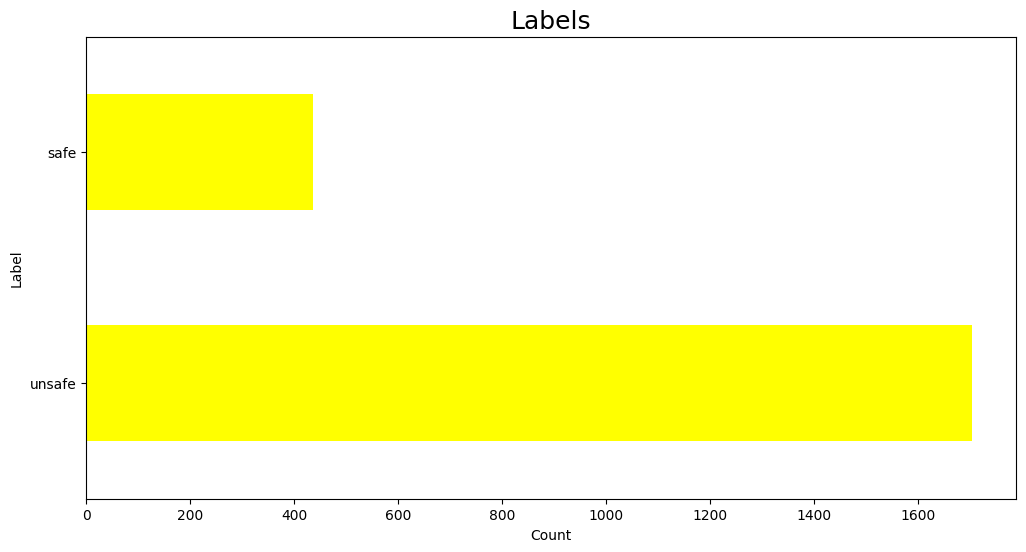

In [8]:
# visualize the label
label = merged_df['label'].value_counts()
plt.figure(figsize=(12,6))
label.plot(kind='barh', color='yellow')
plt.title('Labels', size=18)
plt.ylabel('Label', size=10)
plt.xlabel('Count', size=10)

- Over 400 safe label indicate that over 400 ingredients in the dataset are safe
- while over 1000 unsafe meaning that over 1000 ingredients are not safe (prohibited by EU CosIng Annex II)

## 3. Feature Extraction

In [32]:
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2,3))
X = vectorizer.fit_transform(merged_df['ingredient'])
y = merged_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 4. Model Training

Initialize and Train model

In [33]:
model = LogisticRegression (random_state=42)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


Predict on Test set

In [27]:
y_pred = model.predict(X_test)

Model Evaluation

In [31]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
print("Confustion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

        safe       0.99      0.76      0.86        89
      unsafe       0.94      1.00      0.97       340

    accuracy                           0.95       429
   macro avg       0.96      0.88      0.91       429
weighted avg       0.95      0.95      0.95       429

Accuracy: 0.9487179487179487
ROC-AUC Score: 0.9963317911434237
Confustion Matrix:
[[ 68  21]
 [  1 339]]


without class_weigh='balanced':
- 68 true positives, 
- 21 false negatives (safe flagged as unsafe), 
- 1 false positive (unsafe flagged as safe), 
- 339 true negatives
there are 21 cases that the model will unneccesary alarm the user of unsafe ingredient when it's actually safe

However, with class_weight='balanced':
- 86 true postives, 
- 3 false negatives, 
- 17 false positives, 
- 323 true negatives
there are 17 ingredients misclassified as safe although they're unsafe

In our case, as we value health risk therefore unsafe ingredients shouldn't be miss flagged this much due to health concern.

## 5. Function to Process User Input

These functions handle text and image inputs, clean them, and predict safety.

In [40]:
# clean ingredient from user input
def clean_user_input(text):
    ingredients = text.lower().split(',')
    return [clean_ingredient(i) for i in ingredients if clean_ingredient(i)]

# predict the safety of the ingredients
def predict_safety(ingredients, model, vectorizer):
    # transform inputt to tf-idf features
    X_input = vectorizer.transform(ingredients)
    # predict
    predictions = model.predict(X_input)
    # initialize result
    result = []
    # return reslt
    for ing, pred in zip(ingredients, predictions):
        result.append(f"{ing}: {pred}")
    return "\n".join(result) if result else "No valid ingredients"

# example text input (ingredient of Torriden Balanceful Cream)
text_input = "Water, Butylene Glycol, Glycerin, Heptyl Undecylenate, 1,2-Hexanediol, Centella Asiatica Extract, Madecassic Acid, Asiaticoside, Asiatic Acid, Madecassoside, Panthenol, Allantoin, Hydrolyzed Hyaluronic Acid, Swertia Japonica Extract, Nymphaea Coerulea Flower Extract, Lactobacillus Ferment, Althaea Rosea Flower Extract, Carthamus Tinctorius Flower Extract, Betaine, Caprylic/Capric Triglyceride, Cetearyl Alcohol, Propanediol, C14-22 Alcohols, Dipeptide-2, Acrylates/C10-30 Alkyl Acrylate Crosspolymer, Hydroxyethyl Acrylate/Sodium Acryloyldimethyl Taurate Copolymer, Sodium Polyacrylate, Glyceryl Acrylate/Acrylic Acid Copolymer, PVM/MA Copolymer, Sorbitan Isostearate, Polyglyceryl-3 Polyricinoleate, Isopentyldiol, Capryloyl Salicylic Acid, C12-20 Alkyl Glucoside, Polyglyceryl-4 Oleate, Sodium Stearoyl Glutamate, Sodium Surfactin, Caproic Acid, Xanthan Gum, Tromethamine, Sodium Acetate, Disodium EDTA, Ethylhexylglycerin, Gardenia Florida Fruit Extract"
cleaned_input = clean_user_input(text_input)
print("Result:")
print(predict_safety(cleaned_input, model, vectorizer))

Result:
WATER: unsafe
BUTYLENE GLYCOL: unsafe
GLYCERIN: safe
HEPTYL UNDECYLENATE: unsafe
1: safe
2-HEXANEDIOL: unsafe
CENTELLA ASIATICA EXTRACT: safe
MADECASSIC ACID: safe
ASIATICOSIDE: safe
ASIATIC ACID: safe
MADECASSOSIDE: safe
PANTHENOL: unsafe
ALLANTOIN: safe
HYDROLYZED HYALURONIC ACID: unsafe
SWERTIA JAPONICA EXTRACT: unsafe
NYMPHAEA COERULEA FLOWER EXTRACT: unsafe
LACTOBACILLUS FERMENT: safe
ALTHAEA ROSEA FLOWER EXTRACT: unsafe
CARTHAMUS TINCTORIUS FLOWER EXTRACT: unsafe
BETAINE: unsafe
CAPRYLIC/CAPRIC TRIGLYCERIDE: safe
CETEARYL ALCOHOL: safe
PROPANEDIOL: unsafe
C14-22 ALCOHOLS: unsafe
DIPEPTIDE-2: safe
ACRYLATES/C10-30 ALKYL ACRYLATE CROSSPOLYMER: unsafe
HYDROXYETHYL ACRYLATE/SODIUM ACRYLOYLDIMETHYL TAURATE COPOLYMER: unsafe
SODIUM POLYACRYLATE: unsafe
GLYCERYL ACRYLATE/ACRYLIC ACID COPOLYMER: safe
PVM/MA COPOLYMER: safe
SORBITAN ISOSTEARATE: safe
POLYGLYCERYL-3 POLYRICINOLEATE: safe
ISOPENTYLDIOL: unsafe
CAPRYLOYL SALICYLIC ACID: safe
C12-20 ALKYL GLUCOSIDE: safe
POLYGLYCERYL-

The result is obviously not quite accurate as 
- Water is also considered unsafe because the word appears in the unsafe ingredient (Margosa, ext. [from the kernels of Azadirachta indica extracted with water and further processed with organic solvents]). 
- Some ingredient like Gardenia florida fruit extract is not mentioned but still considered unsafe

In [50]:
# image input
def extract_test_from_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("Image not found or unreadable")
    image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    text = pytesseract.image_to_string(Image.fromarray(image))
    return text

# example image input
try:
    image_text = extract_test_from_image(r"C:\Users\ASUS\OneDrive\KIT\Semester3\MachineLearningWithPython\ml_project2\test images\torriden_ing.jpg")
    cleaned_image_input = clean_user_input(image_text)
    print("Result:")
    print(predict_safety(cleaned_image_input, model, vectorizer))
except Exception as e:
    print(f"Error: {e}")

Result:
BALANCEFUL CICA CREAM | DERMATOLOGICAILY TESTED | | SKIN IRRITATION SOOTHING TESTED | | NON-COMEDOGENIC TESTED | CICA SOOTHING MOISTURIZER FOR SENSITIVE SKIN PROVIDES MOISTURE AND SOOTHES WITH 5D MULTI CENTELLA ASIATICA EXTRACT AND PANTHENOL. INGREDIENTS WATER: unsafe
BUTYLENE GLYCOL: unsafe
GLYCERIN: safe
HEPTY! UNDECYLENATE: unsafe
1: safe
2-HEXANEDIOL: unsafe
PANTHENOI: unsafe
CENTELLA ASIATICA EXTRACT: safe
MADECASSIC ACID: safe
ASIATICOSIDE: safe
ASIATIC ACID: safe
MADECASSOSIDE: safe
ALLANTOIN: safe
HYDROLYZED HYALURONIC ACID: unsafe
SWERTIA JAPONICA EXTRACT: unsafe
NYMPHAEA CAERULEA FLOWER EXTRACT: unsafe
LACTOBACILLUS FERMENT: safe
ALTHAEA ROSEA FLOWER EXTRACT: unsafe
CARTHAMUS TINCTORIUS (SAFFLOWER) FLOWER EXTRACT: unsafe
BETAINE: unsafe
CAPRYLIC/CAPRIC TRIGLYCERIDE: safe
CETEARYL ALCOHOL: safe
PROPANEDIOL: unsafe
C14-22 ALCOHOLS: unsafe
DIPEPTIDE-2. ACRYLATES/C10-30 ALKYL ACRYLATE CROSSPOLYMER: safe
HYDROXYETHY! ACRYLATE/SODIUM T TAURATE LYMER: unsafe
SODIURN POLYACRY

In [51]:
# example image input (BE anti ance spray)
try:
    image_text = extract_test_from_image(r"C:\Users\ASUS\OneDrive\KIT\Semester3\MachineLearningWithPython\ml_project2\test images\anti_acne_spray.jpg")
    cleaned_image_input = clean_user_input(image_text)
    print("Result:")
    print(predict_safety(cleaned_image_input, model, vectorizer))
except Exception as e:
    print(f"Error: {e}")

Result:
PROPYLENE GLYCOL: unsafe
SODIUM LACTATE: unsafe
NIACINAMIDE: unsafe
SALICYLIC ACID: safe
PHENOXYETHANOL: unsafe
LACTIC ACID: safe
ALLANTOIN: safe
DISODIUM EDTA: unsafe
ALCOHOL: unsafe
WATER: unsafe
O-CYMEN-5-OL: unsafe
AND TRIETHYLENE GLYCOL.: unsafe


compare to website like skin sort only:
- propylene glycol (orange)
- phenoxyethanol (red)
- Disodium EDTA (orange)
- Alcohol (red)
- Triethylene Glycol (red)

other green => safe